# The classic Deep-Q Network Pong

A simple Google search of the Pong Reinforcement Learning will probably lead you to an already done implementation, using
Convolutional networks and the Atari Gym environments. 

My goal is not to *replace* those articles, but to try to train an agent using:
- a small observation space,
- a custom environment
- larger screen size

This code should prove useful to anyone who wants to use an editable environment with different hyperparameters, or just to fiddle around with the currently set parameters. Also, since OpenAI Gym has been deprecated, I have updated this to work with *Gymnasium* which is a great replacement since it's backwards compatible, and you can simply use:
```python
        import gymnasium as gym
```
Here I have made all the calls to the gymnasium namespace explicit, to highlight the fact that you have to use Gymnasium instead of the old Gym environment.  

Here is a list of all the versions of packages outside of the standard library, for future compability:
- gymnasium == 0.28.1
- keras == 2.11.0
- tensorflow  2.11.0

## VERY IMPORTANT

You have to register the robopong environment in the gymnasium/env/init file in order for this to work, I have added the following entry point in my init file:
```python
register(
    id="RoboPongEnv-v0",
    entry_point="gym.envs.classic_control.robopongenv:RoboPongEnv",
    max_episode_steps=500_000,
    reward_threshold=1_000_000
)
```

- **RoboPongEnv-v0** - is the name of the .py file 
- **gym.envs.classic_control.robopongenv:RoboPongEnv** - is the path to the file 
- **max_episode_steps** - the number of steps in a single episode when it is considered that the model has converged
- **reward_threshold** - same as for the steps but with the reward

In [3]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import gymnasium
import keras.layers
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy
from rl.policy import LinearAnnealedPolicy
from keras import regularizers
from keras.optimizers import Adam

## LoadTrainedWeights Class

This is a simple keras callback, which I use to load the weight layers. As you will later see, the get weights helps you navigate through training sessions and episodes within those sessions.
I have used a counter since the list_dir call in get_weights_for_model() returns a Windows-sorted list of directories which means it's sorted by its first digit (you get something like *layer-5, layer-51, ... , layer-6, layer-61*).

In [ ]:
class LoadTrainedWeights(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        weight_path, dir_list = get_weights_for_model()
        counter = 0
        for lay in model.get_weights():
            counter += 1
            weight_ = np.loadtxt(os.path.join(weight_path, f"layer-{counter}.csv"), dtype=np.float32, delimiter=",")
            lay = weight_

# GetWeightsWhileTraining Class

I used this class because the keras checkpoint callbacks didn't work. This saves the layers as .csv files with 32-bit precision floats. Layers all have a standard name of layer-(# of layer) since each layer is saved within it's own episode folder.

The every constructor argument is used to set the frequency of saving (keep in mind, by default, this will save the "episode 0" and the last episode if you have a round number of training steps). 

In [ ]:
class GetWeightsWhileTraining(keras.callbacks.Callback):

    def __init__(self, every=5):
        # save weights every (every) episodes
        assert every > 0
        super().__init__()
        self.every = every

    def on_episode_begin(self, episode, logs):
        if episode % self.every == 0:
            weights = model.get_weights()
            model.save_weights(save_model_path + f"episode {episode}")
            episode_dir_path = os.path.join(save_model_path, f"episode-{episode}")
            os.makedirs(episode_dir_path)
            counter = 0
            for w in weights:
                counter += 1
                x = np.array(w)
                np.savetxt(fname=episode_dir_path + f"\\layer-{counter}.csv", X=x, delimiter=",", fmt="%1.32f")

# get_weights_for_model() Method

When I first wrote it, I used it only to load the models, hence the name. It can be used to get any file provided that it is within the same directory/subdirectory as the .py file, due to the os.curdir() call. The method returns a tuple of the name of the current selected path, and a list of all the directories for the given path. The usefulness of this depends on the use case but you can access only one if needed. 

It lists all the available files and folder in the current directory, and raises an error if the chosen option isn't another folder, since this is mostly used just to get a particular filepath.

In [ ]:
def get_weights_for_model():
    path_name = os.curdir
    while 1:
        dir_file_names = []
        try:
            dir_file_names = os.listdir(path_name)
        except WindowsError:
            print("Chosen option was not a folder")
            choice = input("Try again: ")
        for i, file in enumerate(dir_file_names):
            print(f"{i} - {file}")
        choice = input("Choose the folder to load, input a negative integer to exit: ")
        try:
            int(choice)
        except ValueError:
            print("Chosen option is not a valid input")
            choice = input("Try again: ")
        if int(choice) <= -1 or int(choice) >= len(dir_file_names):
            break
        else:
            choice = int(choice)
        path_name = os.path.join(path_name, dir_file_names[choice])
    return path_name, dir_file_names

# create_filename() Method

This one is pretty self-explanatory, in my case, I didn't have a situtation where I needed to create multiple models in the same minute, so it will throw an error if you try to create another model within the same minute, anyways this could be easily modified.

In [ ]:
def create_filename():
    current_time = datetime.now()
    time_format = current_time.strftime("%H-%M")
    model_name = f"pong_run_{time_format}"
    return os.path.join(os.curdir, f"logs/{model_name}")

# visualize_weights() Method

This function I used mostly for debugging and checking if everything is setup as expected, are the weights initialized properly. To generalize this function you could find a list of prime divisors of the number of layers, for my purposes since I knew the specifications of my model, I knew what layer should be in what position and how to arange the subplots.

In [ ]:
def visualize_weights():
    graph_path, dir_list = get_weights_for_model()
    n_rows = 6
    n_cols = 11
    print("n_rows: ", n_rows)
    print("n_rows: ", n_cols)
    all_subplots = []
    for ax in range(n_rows * n_cols):
        all_subplots.append(plt.subplot(n_rows, n_cols, ax + 1))
    for m in range(n_rows * n_cols):
        if os.path.exists(os.path.join(graph_path, f"layer-{m + 1}.csv")):
            weight_ = np.loadtxt(os.path.join(graph_path, f"layer-{m + 1}.csv"), dtype=np.float32, delimiter=",")
            x = np.arange(0, weight_.shape[0], 1)
            if weight_.size > x.size:
                line = all_subplots[m].plot(weight_[0], weight_[1], "bo", alpha=0.01)[0]
            else:
                line = all_subplots[m].plot(weight_, "bo", alpha=.1)[0]
        else:
            print(os.path.join(graph_path, f"layer-{m + 1}.csv"), "doesn't exist")
    plt.show()

# build_model(n_actions) Method

This method is pretty self explanatory, the loss function here is the standard one used in classification problems, though you should keep in mind that the main metric of reinforcement learning problems is the average reward over the episodes. The loss may decrease, and the model can still perform **badly**, the decrease in loss is just because it's getting better at predicting the rewards, the rewards could still be suboptimal.

I have went ahead and chosen two frames per batch of five observations returned from the step function in the environment [paddle y position, ball x position, ball y position, the difference between the paddle x and the ball x, the difference between the paddle y and the ball y]. Thus the model expects two consecutive steps in order to get this information, the flatten layer thus produces a [10, 1]-shaped array (tf.variable at a lower level).

In order to normalize the inputs there's a batch normalization layer prepened before the first activation neuron, the once again before every activation neuron in order to scale the variance of the outputs from each neuron (to prevent from oversaturated neurons). The *he_normal initialization- is the one suggested for the *ELU activation* function in order to prevent the problem of dying neurons.

Since the nature of this project is to use a really small amount of features, I have made a pretty small observation space, the model just gets one point for the location of the paddle, it doesn't know about its width and height, and the same goes for the ball. That's why I used a really small l1 regularization rate, on the other hand the model should get pretty good at estimating and looking for higher rewards, for e.g. you can set up a really high reward after every 20 bounce backs (more details about the reward system can be found in the **robopongenv notebook**), therefore there is a moderate regularization rate on the l2-norm in order to prevent from overfitting to only certain episodes where the model get's a **good enough** reward. 

At the end, a *softmax* activation function with two neurons is set up in order to estimate the probabilty of the actions, when I first made this there used to be three actions (the do nothing action), that only increased the entropy, anyways the model finds a way to stand in place by moving the paddle up and down each frame, after it finds the place where it thinks the ball will hit. 

In [ ]:
def build_model(n_actions):
    model_built = Sequential()
    lr1 = .01
    lr2 = .4

    model_built.loss = keras.losses.sparse_categorical_crossentropy
    model_built.add(keras.layers.InputLayer(input_shape=np.array([2, 5], dtype=int)))
    model_built.add(Flatten())
    activation = keras.layers.activation.ELU()

    for _ in range(10):
        model_built.add(keras.layers.BatchNormalization())
        model_built.add(Dense(500, activation=activation, kernel_initializer="he_normal",
                              kernel_regularizer=regularizers.L1L2(lr1, lr2)))

    model_built.add(Dense(n_actions, activation="softmax"))  # equivalent to sigmoid activation since n=2

    return model_built

# build_agent(model_com, actions_n, warmup, max_eps, min_eps) Method

This is the part where the deep q network gets built. Some of the hyperparameters here are pretty common, since I have commented out a different policy which could be used, but in my experience it didn't necessarily lead to a better model, I opted out for the EpsGreedyQPolicy with a slow decay of the epsilon. With this setup, the q-values converged most of the time after 2 million timesteps.

## I very strongly advise to keep the enable double dqn as true, and partial updates of the network

At first I wanted to make a model that doesn't require the astounding discovery of the frozen and the online network. This significantlly improves the stability of the model, and decreases the number of episodes required, in short it made my and my laptops life a lot easier, you could potentially consider not using these options but you will have to really fight against instability of the network which you might discover 2-3 days into training the model.

### Experience replay too

If you take a deeper look at the DQNAgent API you will see that it uses experience replay by default. In the first version, I made my own method for experience replay and compared it to a model that does not use experience replay, the latter was vastly inferior to the first one. Therefore it is best to make a sizeable buffer for steps, even at the expense of the speed of the training.

In [ ]:
def build_agent(model_com, actions_n, warmup=True, max_eps=1, min_eps=0.01):
    # policy = MaxBoltzmannQPolicy(eps=0.01)
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr="eps", value_max=0.9999, value_min=0.01, value_test=0.5,
                                  nb_steps=STEPS_NUMBER)
    memory = SequentialMemory(limit=1_000_000, window_length=2)
    dqn_com = DQNAgent(model=model_com, memory=memory, policy=policy, nb_actions=actions_n,
                       nb_steps_warmup=0.000001 * STEPS_NUMBER * warmup, target_model_update=1e-5,
                       batch_size=16, gamma=.95, enable_double_dqn=True)
    return dqn_com

# get_x_y_coordinates(x, y, w, z, x_array, y_array) Method

This recursively called method appends all the points at which the ball bounces, and at the end the (x, y) coordinates where the ball should land on the paddle side of the screen. I use this to make a plot, as seen in the example bellow, of the balls trajectory. This is the only function which had to be a bit complicated in order to get things to work, but it shouldn't cause to much trouble it just determines wether the ball hits one of the ceiling or the opposite rect.

In [4]:
def get_x_y_coordinates(x, y, w, z, x_array, y_array):
    if 0 < y < 400:
        y += z
    else:
        x_array.append(x)
        y_array.append(y)
        z = -z
        y += z

    if 0 < x:
        x += w
    else:
        x_array.append(x)
        y_array.append(y)
        w = -w
        x += w
    while x < 800:
        return get_x_y_coordinates(x, y, w, z, x_array, y_array)
    x_array.append(x)
    y_array.append(y)

Here is a minimal use case of the function, here I have arranged the plot ticks for the x and y axis in the way that PyGame sees it, the first coordinate (0,0) is at the top left corner of the screen.

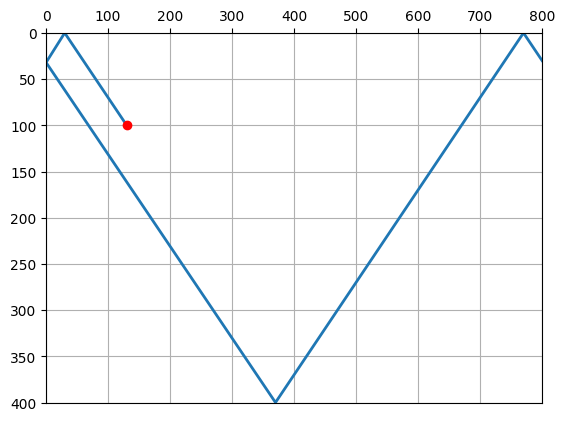

In [5]:
x_start = 130
y_start = 100
direction_x = -2
direction_y = -2
x_points = [x_start]
y_points = [y_start]

get_x_y_coordinates(x_start, y_start, direction_x, direction_y, x_points, y_points)

plt.figaspect(400/800)
plt.xlim(0, 800)
plt.ylim(400, 0)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.grid()
plt.plot(x_points, y_points, linewidth=2)
plt.plot(x_points[:1], y_points[:1], "ro")

Working directly with layers, since the get the observation space for two consecutive steps you can get the movement of the ball. If the x-position in the first observation is smaller than the x-position in the second observation that means that the ball is going away, so + 2 should be added, and conversely. The same goes for the y observation space.  

In [ ]:
path_for_episode_observations = get_weights_for_model()[0]
observation_layer = os.path.join(path_for_episode_observations, "layer-3.csv") # layer 3 is the input with the observations
output_layer = os.path.join(path_for_episode_observations, "layer-66.csv")
# layer 66 is where the pure softmax outputs are, this should be used in conjuction with np.argmax()
# in order to get the action which the model predicted for this episode
pd_observation = pd.read_csv(observation_layer, header=None)
pd_output = pd.read_csv(output_layer, header=None)
print(pd_observation.iloc[:])
print(np.argmax(pd_output.iloc[:]))

x_start_ep = pd_observation.iloc[1].iloc[0]
y_start_ep = pd_observation.iloc[2].iloc[0]
direction_x_ep = ((x_start_ep - pd_observation.iloc[6].iloc[0]) < 0) * -2 + ((x_start_ep - pd_observation.iloc[6].iloc[0]) > 0) * 2
direction_y_ep = ((y_start_ep - pd_observation.iloc[7].iloc[0]) < 0) * -2 + ((x_start_ep - pd_observation.iloc[7].iloc[0]) > 0) * 2
x_points_ep3 = [x_start_ep]
y_points_ep3 = [y_start_ep]

get_x_y_coordinates(x_start_ep, y_start_ep, direction_x_ep, direction_y_ep, x_points_ep3, y_points_ep3)

for i, j in zip(x_points_ep3, y_points_ep3):
    print("x-coordinate: ", i, " y-coordinate: ", j)

Here the model is actually set to train, last time I trained it was in Februrary of 2023, sadly due to a hard drive failure I have lost the trained weights for this model. Currently I am waiting for my AWS account to be validated (credit card issues) so I can re-train the model fully, the model converged in about 7 million time steps.

## If you want to train the model set the visualize parameter to False

Watching the model try to learn and fit to different situations is fun, though using PyGame really slows down the training, therefore you should just trust the process and let your machine run it for a few days. On my laptop it took about 5 days to get to 10 million timesteps, I left it running while vacationing, that's why probably I will not train the model until I get an AWS account. The gymnasium.make will call pygame.init() I have kept this in order to know that the pygame is up and running, you can freely click away and do other things while the model is being trained, though I would not advise for this since running other programs which consume ram/gpu might hinder the performance. Also keep in mind the *accuracy* is performed against the aforementioned experience replay buffer. And make sure to have around 100gb of space available for weights.  

In [ ]:
save_model_path = create_filename()

env = gymnasium.make("RoboPongEnv-v0")
STEPS_NUMBER = 10_000_000

actions = env.action_space.n
model = build_model(actions)
dqn = build_agent(model, actions)

dqn.compile(Adam(learning_rate=0.00025, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])
history = dqn.fit(env, nb_steps=STEPS_NUMBER, visualize=True, verbose=2, callbacks=[GetWeightsWhileTraining()])

Here is a minimal example of how to use the model to get predictions. The env.reset() method has to be called first in order to call env.step, then use the predicted actions

In [ ]:
while 1:
    env.reset()
    # dummy moves for prediction
    step_run = [[[env.step(0)[0], env.step(1)[0]]]]
    for i in range(10000):
        actions = model.predict(step_run)
        step1 = env.step(int(actions[0, 0]))
        step2 = env.step(int(actions[0, 1]))
        env.render()
        # if one of the steps returns true for terminated, then reset
        if step1[2] or step2[2]:
            env.reset()
        step_run = [[[step1[0], step2[0]]]]
    break